The aim of this challenge is to “classify drugs based on their biological activity”. Pharmaceutical drug discovery aims to identify certain proteins that are associated with a specific disease, and then to develop molecules that can target those proteins. The MoA of a molecule encodes its biological activity. Our dataset describes the responses of 100 different types of human cells to various drugs. Those response patterns will be used to classify the MoA reponse.

This is a multi-label classification problem. Drugs can have multiple MoA annotations which describe binary responses from different cell types in different ways. The evaluation metric is the mean columnwise log loss.

The data comes in the familiear shape of train and test files. In contrast to other competitions, here we have two separate files for the training predictors (train_features.csv) and the targets (train_targets_scored.csv). Each row corresponds to a specific treatment. In addition, we are also given an optional set of MoA targets (train_targets_nonscored.csv) that we don’t need to predict, but can use for context analysis.

The specific goal is to predict the train_targets_scored.csv class probabilities for the the test file test_features.csv. Note, that the public leaderboard is based on approximately 25% of this test data, with 75% being assigned to the private LB.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing 
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
train_drug = pd.read_csv('../input/lish-moa/train_drug.csv')

check number of features in the train set

In [3]:
train_features.shape, train_targets_scored.shape, train_targets_nonscored.shape, train_drug.shape

((23814, 876), (23814, 207), (23814, 403), (23814, 2))

In [240]:
train_drug.head()

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131


In [242]:
train_features.cp_dose.unique()

array(['D1', 'D2'], dtype=object)

In [4]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


- This training set has 3 categorical columns: "cp_type", "cp_time", and "cp_dose"
- Two groups of numerical sets" (1) gene feature start with "g-" (2) cell feature start with "c"

In [5]:
gene_train =  train_features.filter(regex = 'g-')

In [6]:
gene_train.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


This is a rather wide dataset with almost 900 columns. From the data description we learn that features starting with “g-” encode gene expression data (there are 772 of those)

__Visulization of the gene expression features__

Those are essentially anonymised features, labelled from “g-0” to “g-771”. Their values are numeric, so let’s look at the densities for the first 4 gene features as an example:

<AxesSubplot:xlabel='g-0', ylabel='Density'>

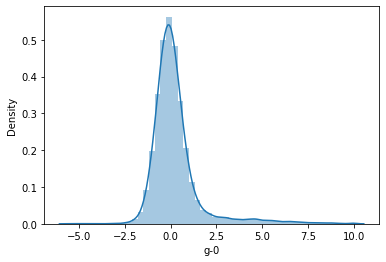

In [23]:
sns.distplot(gene_train['g-0'])

<AxesSubplot:xlabel='g-1', ylabel='Density'>

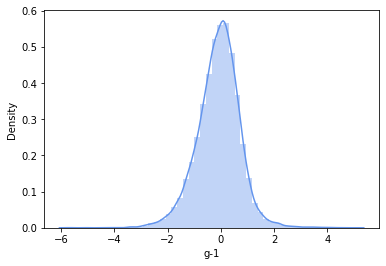

In [34]:
sns.distplot(gene_train['g-1'],color='#6495ED')

<AxesSubplot:xlabel='g-3', ylabel='Density'>

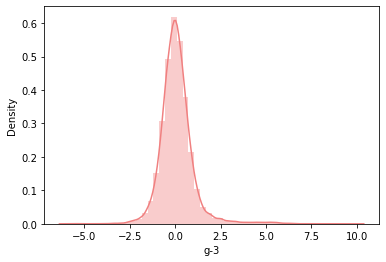

In [35]:
sns.distplot(gene_train['g-3'],color="#F08080")

<AxesSubplot:xlabel='g-4', ylabel='Density'>

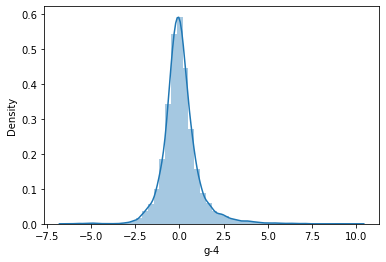

In [26]:
sns.distplot(gene_train['g-4'])

Those distributions look pretty normal, which is good. There’s a bit of skew in some of them, but nothing that should warrant a transformation.

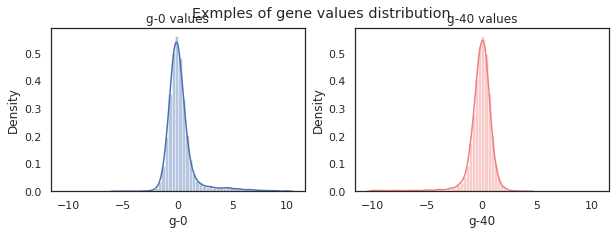

In [254]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
fig.suptitle('Exmples of gene values distribution')
sns.distplot(gene_train['g-0'],ax = axes[0])
axes[0].set_title('g-0 values')

sns.distplot(gene_train['g-40'],ax = axes[1],color="#F08080")
axes[1].set_title('g-40 values');

fig.savefig('gene_val_dist.png')

In [7]:
cell_train = train_features.filter(regex = 'c-')

In [8]:
cell_train.head()

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,-0.0600,0.1083,0.6864,0.4043,0.4213,-0.6797,0.2888,0.4323,-0.3381,0.3407,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0.0927,0.2723,0.2772,0.7776,0.3679,0.5696,0.2835,1.4080,0.3745,0.6775,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,-0.1312,-1.4640,0.3394,-1.7790,0.2188,0.5826,-0.7513,0.0543,0.7182,-0.4159,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,-0.3998,-4.5520,-2.7350,-1.9630,-2.8610,-1.2670,-2.5830,-0.5036,-3.1590,-1.8510,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,-0.3774,0.7364,-0.1659,0.2341,1.0060,0.3204,-0.0852,-0.2284,-0.2533,-0.3174,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


features starting with “c-” (100 in total) show cell viability data.


__cell expression visulization__

Similar to the gene features, the cell viability features are anonymous, labelled from “c-0” to “c-99”; 100 features. Their distributions look as follows:

Similar to the gene features, the cell viability features are anonymous, labelled from “c-0” to “c-99”; 100 features. Their distributions look as follows:

<AxesSubplot:xlabel='c-0', ylabel='Density'>

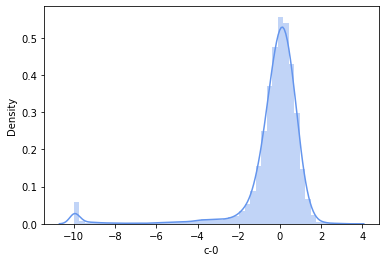

In [30]:
sns.distplot(cell_train['c-0'],color="#6495ED")

<AxesSubplot:xlabel='c-10', ylabel='Density'>

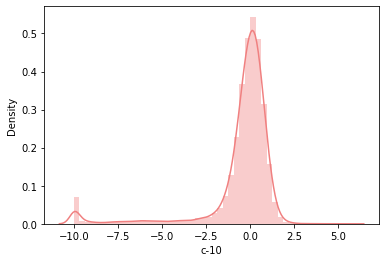

In [37]:
sns.distplot(cell_train['c-10'],color="#F08080")

Also reasonably normal, but with notable bumps around values of -10. Seems the min value cutoff is -10 so any values less than -10 will be assigned -10

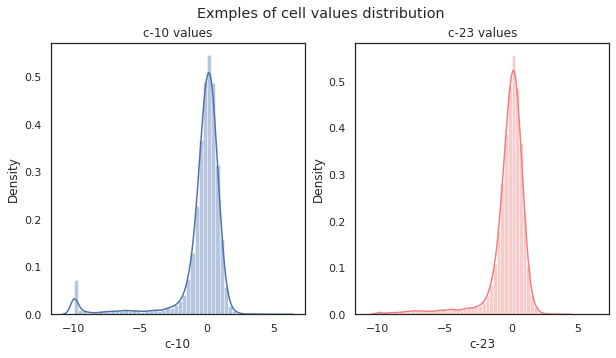

In [256]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Exmples of cell values distribution')
sns.distplot(cell_train['c-10'],ax = axes[0])
axes[0].set_title('c-10 values')

sns.distplot(cell_train['c-23'],ax = axes[1],color="#F08080")
axes[1].set_title('c-23 values');

fig.savefig('cell_val_dist.png')

### take a look at the train target scored set

In [9]:
train_targets_scored.shape

(23814, 207)

In [10]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


check the label distribution in each target 

In [11]:
target_cols = [col for col in train_targets_scored.columns if col not in ['sig_id']]
train_targets_scored[target_cols].sum(axis=0).min(), train_targets_scored[target_cols].sum(axis=0).max(), \
train_targets_scored[target_cols].sum(axis=0).mean()


(1, 832, 81.76699029126213)

In [12]:
train_targets_scored.shape

(23814, 207)

__Non-zeros Targets counts for entries__

<AxesSubplot:ylabel='Count'>

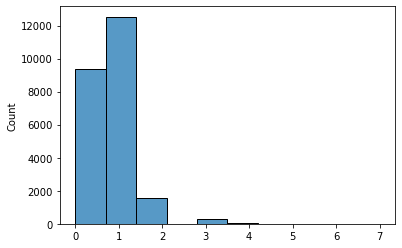

In [52]:
sns.histplot(train_targets_scored[target_cols].sum(axis=1), bins=10)

About 39% of training samples have no MoA annotations at all (e.g. all the target classes have values of zero). This goes a certain way to explain the sparse target dataframe, if 40% of it are completely empty.

The largest group, with a bit more than 50% of samples, has exactly 1 MoA annotation (e.g. one class = one value of “1” in its row).

For more than 1 MoA annotation, we see a tail that extends down to 7 simultaneous MoAs (for 0.03% of cases). Only the case of 2 MoAs is just above 5%, and 3 MoAs is slighly above 1%. Every other case is significantly rarer. Note, that there is no instance with 6 MoAs.

The class of maximum number of non-zero value is 832 and the minimum number of "1" is 1.

__MOA counts per class distribution__

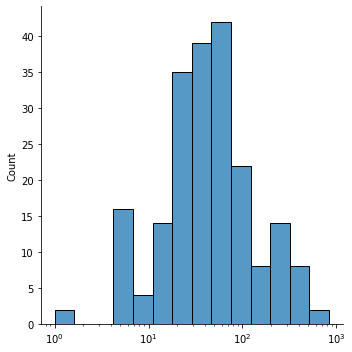

In [68]:
ax = sns.displot(train_targets_scored[target_cols].sum(axis=0), log_scale=True)

In [67]:
train_targets_scored[target_cols].sum().sort_values(ascending=False)

nfkb_inhibitor                                832
proteasome_inhibitor                          726
cyclooxygenase_inhibitor                      435
dopamine_receptor_antagonist                  424
serotonin_receptor_antagonist                 404
                                             ... 
protein_phosphatase_inhibitor                   6
autotaxin_inhibitor                             6
diuretic                                        6
erbb2_inhibitor                                 1
atp-sensitive_potassium_channel_antagonist      1
Length: 206, dtype: int64

"nfkb_inhibitor", as the most freq drug target in the data, from [wiki](https://en.wikipedia.org/wiki/NF-%CE%BAB#Inhibitors_of_NF-%CE%BAB_activity),  a.k.a NF-κB (nuclear factor kappa-light-chain-enhancer of activated B cells) is a protein complex that controls transcription of DNA, cytokine production and cell survival. NF-κB is found in almost all animal cell types and is involved in cellular responses to stimuli such as stress, cytokines, free radicals, heavy metals, ultraviolet irradiation, oxidized LDL, and bacterial or viral antigens.

Since it's a multilable problems, there would be multiple postive labels in one record.

In [18]:
train_targets_scored[target_cols].sum(axis=1).min(),train_targets_scored[target_cols].sum(axis=1).max()

(0, 7)

 Individual feature visualisations

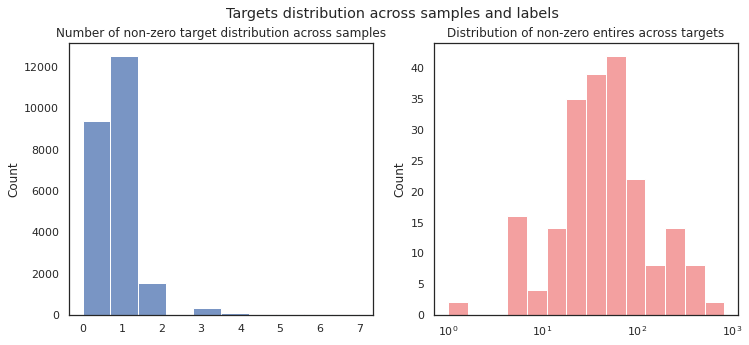

In [263]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(12,5))
fig.suptitle('Targets distribution across samples and labels')

sns.histplot(train_targets_scored[target_cols].sum(axis=1), bins=10,ax = axes[0])
axes[0].set_title('Number of non-zero target distribution across samples')

# sns.distplot(cell_train['c-23'],ax = axes[1],color="#F08080")
sns.histplot(train_targets_scored[target_cols].sum(axis=0), ax = axes[1], log_scale=True,color="#F08080")
axes[1].set_title('Distribution of non-zero entires across targets');
#displot
fig.savefig('target_val_dist.png')

### Feature interactions exploration

__Gene expression interactions__

In [74]:
gene_corr = gene_train.corr()

In [77]:
gene_corr_val = gene_corr.values

<AxesSubplot:>

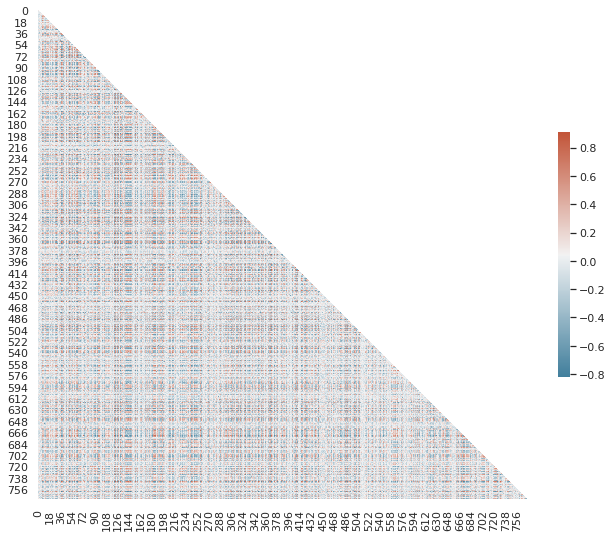

In [93]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gene_corr_val, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(gene_corr_val, mask=mask,cmap = cmap,center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})


sns.heatmap(gene_corr_val,mask=mask,cmap = cmap,cbar_kws={"shrink": .5},square=True)

It doesn’t tell us much about individual features, but there’s certainly some patterns to be seen.It looks like there’s an order in which the features are at least somewhat correlated or anti-correlated; 

Based on this overview, it should be sufficient to have a closer look at a subset of features. The closer look at first 20 gene features

In [96]:
gene_corr_25 = gene_corr.iloc[:20,:20]

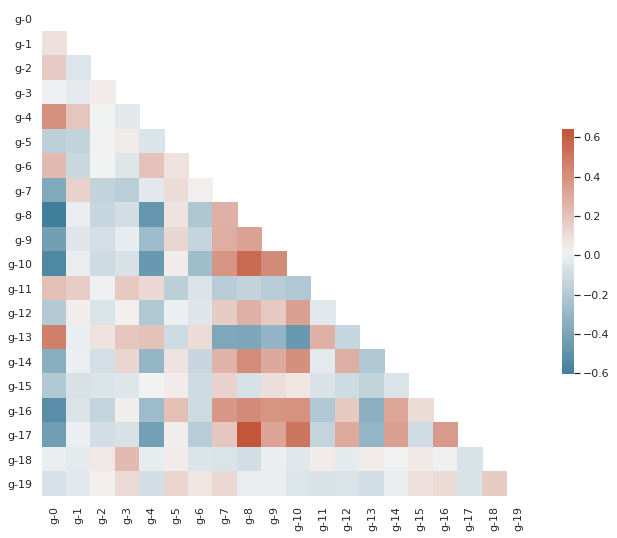

In [264]:

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gene_corr_25, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(gene_corr_val, mask=mask,cmap = cmap,center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})


heat_gene = sns.heatmap(gene_corr_25,mask=mask,cmap = cmap,cbar_kws={"shrink": .5}, square=True)
fig = heat_gene.get_figure()
fig.savefig("heatmap_gene.png") 

Here we have the first 20 gene features. Certain stronger correlations are apparent; such as “g-0” vs “g-8” (neg-correlation), or “g-8” vs “g-10” (pos-correlation).

__Cell features interactions__

In [102]:
cell_train_corr = cell_train.corr()

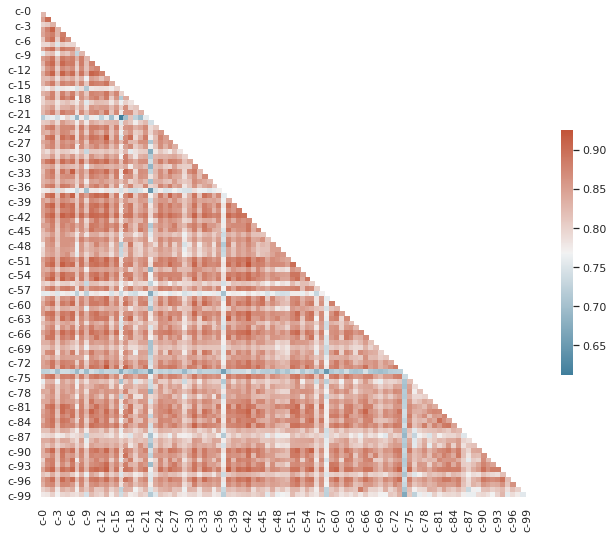

In [265]:

sns.set_theme(style="white")

# Generate a large random dataset
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cell_train_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(gene_corr_val, mask=mask,cmap = cmap,center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})


heat_cell = sns.heatmap(cell_train_corr,mask=mask,cmap = cmap,cbar_kws={"shrink": .5}, square=True)
fig = heat_cell.get_figure()
fig.savefig("cellmap_gene.png") 

Most of the cell features are postive correlated, only a few of cell shows negative correlations.

__Interaction between predictors(features) vs target__

In [105]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


select one cell feature and one gene feature to investigate the the duration effect

In [107]:
train_feat_copy = train_features.copy()

In [109]:
train_targets_scored_copy = train_targets_scored.copy()

In [110]:
train_feat_copy['num_MOA'] = train_targets_scored[target_cols].sum(axis=1)

Based on the number of non-zeros in each sample, create a new type of categories to deal with the few samples that has more than 3 non-zero entries

In [116]:
def num_moa_cat(row):
    if row <3:
        return str(row)
    else:
        return "3+"

In [118]:
train_feat_copy['num_MOA_cat'] = train_feat_copy['num_MOA'].apply(lambda x: num_moa_cat(x))

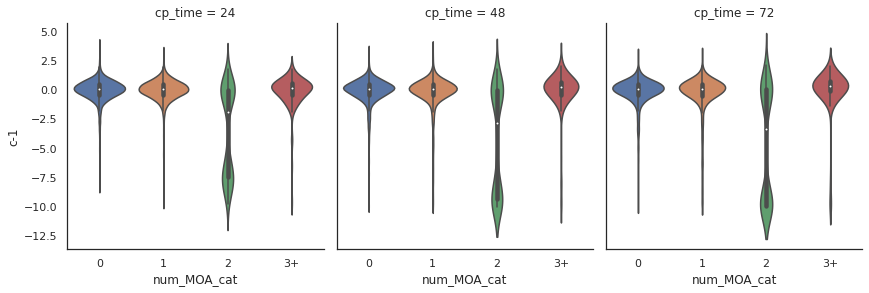

In [267]:
c = sns.catplot(x="num_MOA_cat", y="c-1",
                col="cp_time",
                order=["0", "1","2","3+"],
                data=train_feat_copy, kind="violin", split=True,
                height=4, aspect=1);

fig = c.fig
fig.savefig("time_MOA_cat_cell.png") 

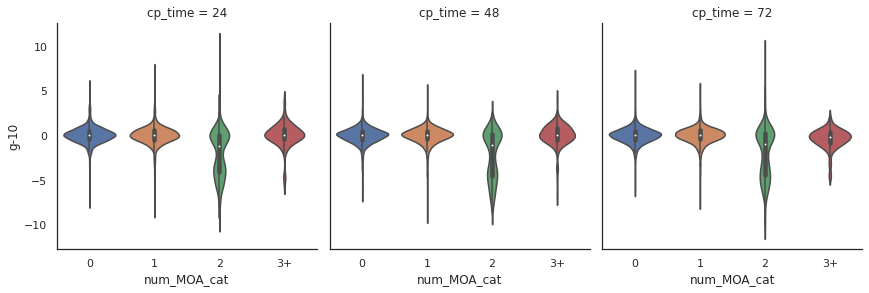

In [268]:
c = sns.catplot(x="num_MOA_cat", y="g-10",
                col="cp_time",
                order=["0", "1","2","3+"],
                data=train_feat_copy, kind="violin", split=True,
                height=4, aspect=1);
fig = c.fig
fig.savefig("time_MOA_cat_g.png") 

There are notable difference between those cases with 0 or 1 vs 2 or more MoAs. In particular, the 2 MoA category appears to account for most of the negative tail in the cell features (and some genes, too; check out “g-8”). In contrast, the “3+” group looks more similar to the “0” and “1” group (except with smaller sample sizes).

There are some slight differences between the cp_time durations for the “2” and “3+” groups. Both the “0” and the “1” group look pretty stable across the board.

### Dimensionality reduction via PCA

Given the amount of correlations in the gene and, especially, the cell features, let’s test some dimensionality reduction methods, to see by how much we could reduce our feature space.

PCA is essentially a rotation of the parameter space so that the new axes (the “principal components” aka PC) are orthogonal and align with the directions of maximum variance. We’ll start with the gene features, then look at the cell features.

In [142]:
from sklearn.decomposition import PCA

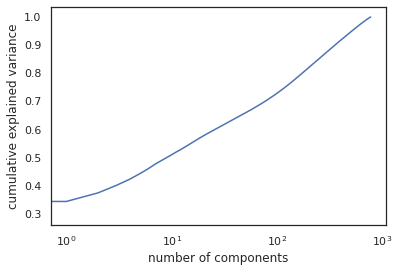

In [270]:
pca_gene = PCA().fit(gene_train)
plt.plot(np.cumsum(pca_gene.explained_variance_ratio_))
plt.xscale("log")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.savefig("gene_PCA_exp_vari.png")

The cumulative explained varaince is shown under the log scale of number of componentgene PCA. The first 10 components has more than 30% of cumu explianed variance.The frist 100 compnenets takes 70% of cumulative explained varaince. 

In [143]:
gene_train.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


In [165]:
pca_gene_2 = PCA(n_components=2).fit(gene_train)

In [166]:
X_pca_gene = pca_gene_2.transform(gene_train)

In [172]:
gen_pca_2 = pd.DataFrame(data =X_pca_gene,columns = ['gen_pca1','gen_pca2'])

In [173]:
train_gen_pca2 = pd.concat([train_feat_copy,gen_pca_2],axis=1)

In [174]:
train_gen_pca2.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-94,c-95,c-96,c-97,c-98,c-99,num_MOA,num_MOA_cat,gen_pca1,gen_pca2
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,1,-8.270396,-0.441144
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,0,-6.625608,3.428337
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,3+,-1.727251,2.336437
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,0,9.222808,-4.738815
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,1,-7.260620,0.297139


<AxesSubplot:xlabel='gen_pca1', ylabel='gen_pca2'>

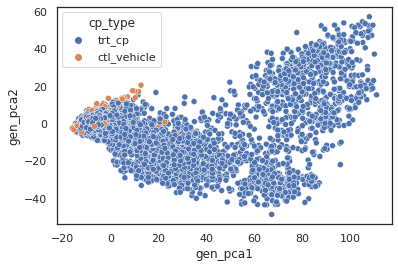

In [177]:
sns.scatterplot(data=train_gen_pca2, x='gen_pca1', y='gen_pca2', hue="cp_type")

<AxesSubplot:xlabel='gen_pca1', ylabel='gen_pca2'>

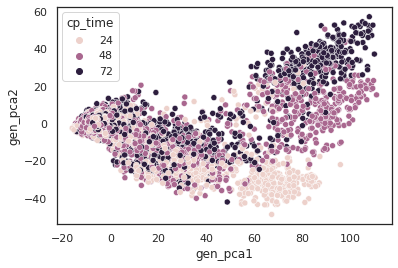

In [178]:
sns.scatterplot(data=train_gen_pca2, x='gen_pca1', y='gen_pca2', hue="cp_time")

<AxesSubplot:xlabel='gen_pca1', ylabel='gen_pca2'>

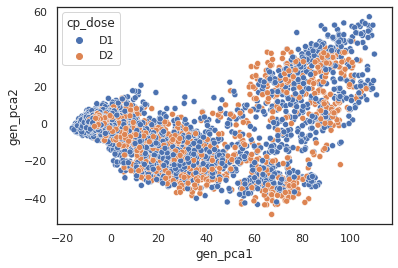

In [179]:
sns.scatterplot(data=train_gen_pca2, x='gen_pca1', y='gen_pca2', hue="cp_dose")

<AxesSubplot:xlabel='gen_pca1', ylabel='gen_pca2'>

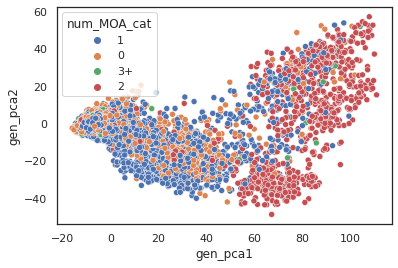

In [182]:
sns.scatterplot(data=train_gen_pca2, x='gen_pca1', y='gen_pca2', hue="num_MOA_cat")

There’s quite a bit of separation and clustering here; which is promising.

The control treatments show much tighter clustering in the first two PCs than the real compound treatments. Given their nature, this isn’t too surprising.

The distributions for doses 1 vs 2 match pretty well. This is consistent with what we had seen so far about this feature.

The treatment durations, on the other hand, show some separation along one side of the parameter space. Similarly, the rowwise sums of MoAs suggest some clustering, especially for sum = 2 vs 0 and 1.

__Cell features PCA__

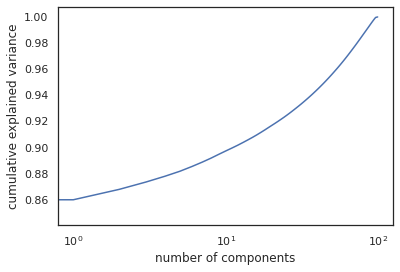

In [269]:
pca_cell = PCA().fit(cell_train)
plt.plot(np.cumsum(pca_cell.explained_variance_ratio_))
plt.xscale("log")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.savefig("cell_PCA_exp_vari.png")

As expected from the previous cell correlation analysis, the cumulative explained variance is shown under the log scale of number of component cell PCA. The first 10 components has more than 85% of cumu explainable variance.

In [187]:
pca_cell_2 = PCA(n_components=2).fit(cell_train)

In [188]:
X_pca_cell = pca_cell_2.transform(cell_train)

In [189]:
cell_pca_2 = pd.DataFrame(data =X_pca_cell,columns = ['cell_pca1','cell_pca2'])

In [190]:
train_cell_pca2 = pd.concat([train_feat_copy,cell_pca_2],axis=1)

In [191]:
train_cell_pca2.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-94,c-95,c-96,c-97,c-98,c-99,num_MOA,num_MOA_cat,cell_pca1,cell_pca2
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,1,-7.339921,0.600995
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,0,-7.477374,-0.752477
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,3+,-2.303507,0.221943
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,0,13.893264,7.334431
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,1,-6.364097,0.257984


<AxesSubplot:xlabel='cell_pca1', ylabel='cell_pca2'>

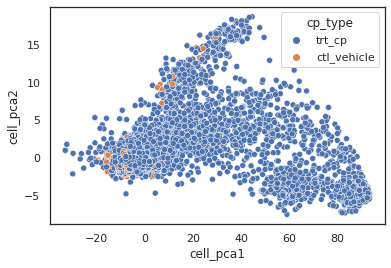

In [192]:
sns.scatterplot(data=train_cell_pca2, x='cell_pca1', y='cell_pca2', hue="cp_type")

<AxesSubplot:xlabel='cell_pca1', ylabel='cell_pca2'>

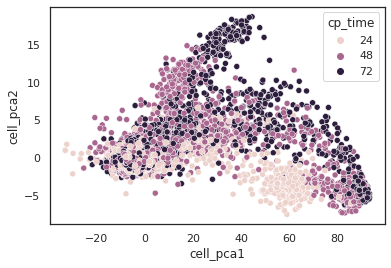

In [193]:
sns.scatterplot(data=train_cell_pca2, x='cell_pca1', y='cell_pca2', hue="cp_time")

<AxesSubplot:xlabel='cell_pca1', ylabel='cell_pca2'>

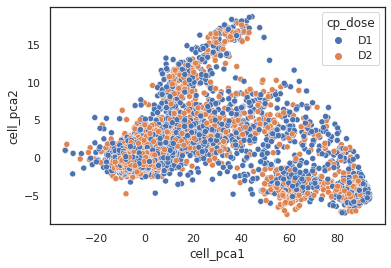

In [194]:
sns.scatterplot(data=train_cell_pca2, x='cell_pca1', y='cell_pca2', hue="cp_dose")

<AxesSubplot:xlabel='cell_pca1', ylabel='cell_pca2'>

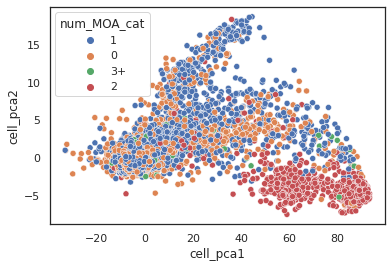

In [195]:
sns.scatterplot(data=train_cell_pca2, x='cell_pca1', y='cell_pca2',  hue="num_MOA_cat")

Feature-wise distributions are pretty similar to what we’ve seen in the gene variables. Compound treatments much more extended than control, D1 and D2 overlap closely, more stratification in treatment duration and MoA sum.

For the durations, it’s particularly the 24-hour group that stands out. The 48h and 72h groups separate a bit better at the edges of the PC space, but otherwise overlap resonably closely.

For MoA sums, it’s again the sum = 2 group which is most different from the rest.,

Originally, this comptetion use multilable log loss the the evaluation metrics. Here, since I plan to predict signle MOA, so I can use F1 score, accuracy as the evaluation metrics. "nfkb_inhibitor" is selected as the MOA for the prediction target.

Original features and preprocessed features as PCA is used

The classifiction models for this tasks proposed as Linear SVM


In [198]:
original_train = train_features.filter(regex = 'g-|c-')

In [199]:
target = train_targets_scored['nfkb_inhibitor']

Postive label are only take 0.0349 of the whole sample

In [200]:
from sklearn.svm import LinearSVC

In [221]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import numpy as np




def model_eval(clf, X, y):
    mean_f1_score= 0
    mean_conf_mat = np.zeros((2,2))
    
    skf = StratifiedKFold(n_splits=5)

    for i, (train, test) in enumerate(skf.split(X, y)):

        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        f1 = f1_score(y[test], y_pred)
        

        
        conf_mat = confusion_matrix(y[test], y_pred)
        print("-------------------------------")
        print(f"fold {i}, f1 score {f1}")
        mean_f1_score += f1/5
        mean_conf_mat += conf_mat/5
        
    return mean_f1_score, mean_conf_mat


In [222]:
original_train.shape

(23814, 872)

In [228]:
target.shape

(23814,)

In [281]:
original_train.shape

(23814, 872)

In [223]:
X = original_train.to_numpy()
y=target.to_numpy()

linear_svc_clf = LinearSVC()
f1,conf_mat = model_eval(linear_svc_clf, X, y)

-------------------------------
fold 0, f1 score 0.7675675675675676
-------------------------------
fold 1, f1 score 0.7459459459459461
-------------------------------
fold 2, f1 score 0.7454068241469816
-------------------------------
fold 3, f1 score 0.7713498622589531
-------------------------------
fold 4, f1 score 0.7338935574229692


In [229]:
f1, conf_mat

(0.7528327514684835,
 array([[4533.2,   63.2],
        [  27.8,  138.6]]))

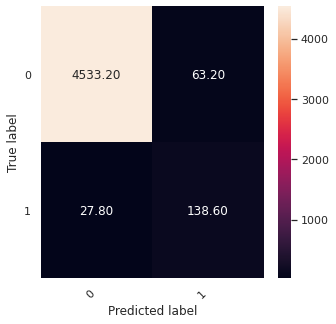

In [279]:
figsize = (5,5)
class_names = ["0","1"]
df_cm = pd.DataFrame(
    conf_mat, index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=figsize)
try:
    heatmap = sns.heatmap(df_cm, annot=True,fmt=".2f")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("conf_matrix_full_feat.png")

__PCA perdiction performance__

Use PCA features of genes and cells. For gene, use n_components = 100; for cell, use n_components = 10

In [234]:
pca_cell_10 = PCA(n_components=10).fit(cell_train)
X_pca_cell = pca_cell_10.transform(cell_train)
pca_gene_100 = PCA(n_components=100).fit(gene_train)
X_pca_gene = pca_gene_100.transform(gene_train)

pca_features = np.concatenate([X_pca_cell,X_pca_gene],axis=1)


In [238]:
X = pca_features
y=target.to_numpy()

linear_svc_clf = LinearSVC()
f1_pac,conf_mat_pca = model_eval(linear_svc_clf, X, y)

-------------------------------
fold 0, f1 score 0.8882175226586103
-------------------------------
fold 1, f1 score 0.8827160493827162
-------------------------------
fold 2, f1 score 0.9009009009009009
-------------------------------
fold 3, f1 score 0.9
-------------------------------
fold 4, f1 score 0.8309859154929577


In [239]:
f1_pac,conf_mat_pca

(0.8805640776870369,
 array([[4584.8,   11.6],
        [  26. ,  140.4]]))

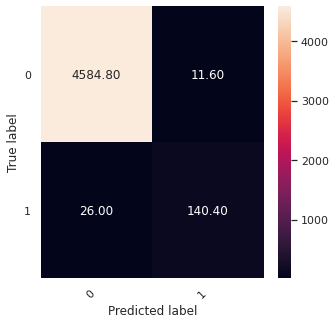

In [280]:
figsize = (5,5)
class_names = ["0","1"]
df_cm = pd.DataFrame(
    conf_mat_pca, index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=figsize)
try:
    heatmap = sns.heatmap(df_cm, annot=True,fmt=".2f")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("conf_matrix_pca_feat.png")